<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/rosewambui/simple-cnn-with-pytorch

In [30]:
# visualization tools
import matplotlib.pyplot as plt

# torch- Our deep learning framework
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim

# from other notebooks
# import import_ipynb
# from dataloaders import DataLoader


Load MNIST dataset both train and test

In [31]:
# load MNIST dataset both train and test
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [32]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [33]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Visualization of MNIST dataset

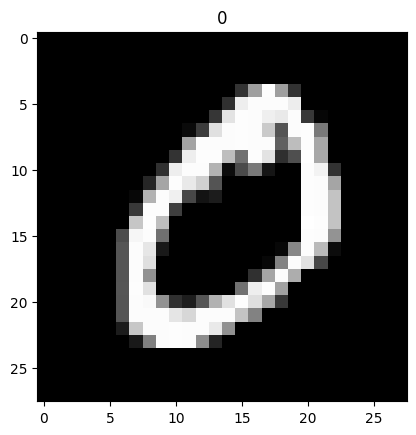

In [34]:

plt.imshow(train_data.data[1], cmap='gray')
plt.title('%i' % train_data.targets[1])
plt.show()

Plot multiple train_data

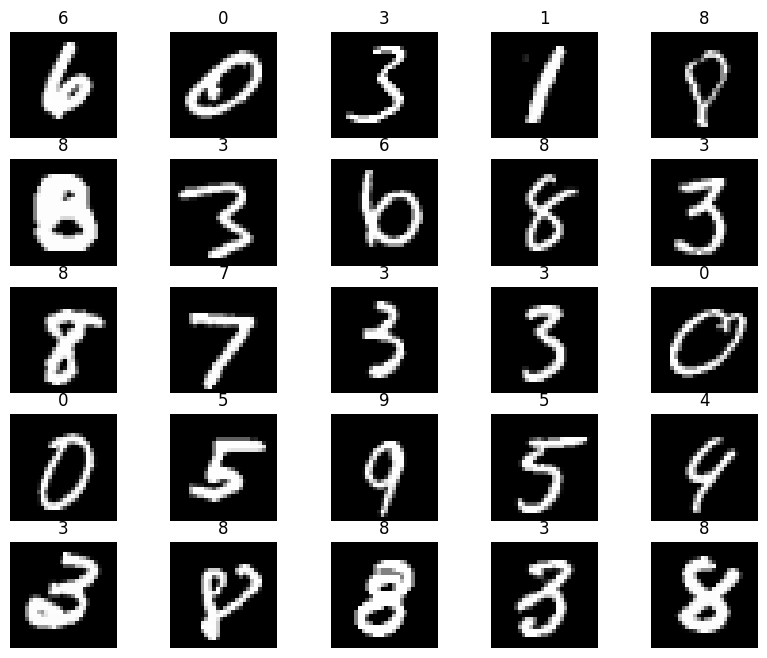

In [35]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Dataloader will allow us to reshuffle the data to avoid overfitting and use mini-batches to train

In [36]:
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)


In [37]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([100, 1, 28, 28])

This means we have 1000 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one)

In [38]:
# Create DataLoader for MNIST
# mnist_loader = DataLoader(dataset_name='MNIST')

##### Convolutional layer, fully connect layer and forward pass

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Feature extraction (convolution)
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fully connected layer
        self.fc_model = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),  # 64 channels, 7x7 feature map size
            nn.ReLU(),
            nn.Linear(128, 10)  # Output size is 10 for 10 classes (digits 0-9)
        )

    def forward(self, x):
        x = self.cnn_model(x)  # Feature extraction
        x = x.view(x.size(0), -1)  # Flatten the inputs
        x = self.fc_model(x)  # Fully connected layers
        return F.log_softmax(x, dim=1)  # Softmax activation for classification


In [40]:
model = CNN()

In [41]:
# loss function
loss_func = nn.CrossEntropyLoss()

In [42]:
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

Training

In [43]:
def train(epoch):

    # Setting model in training mode.
    model.train()

    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        #clear gradient
        optimizer.zero_grad()

        #FP (make a prediction)
        output = model(data.float())

        # calculating the loss
        loss = loss_func(output, target)

        #BP, Computing the gradient of the loss w.r.t the parameters of the model
        loss.backward()

        # a single step of optimization, update parameters
        optimizer.step()

        train_loss += loss.item()

        _, pred = output.max(1)
        train_acc += target.eq(pred).sum().item()

    train_acc /= len(train_loader.dataset)
    train_loss /= (batch_idx + 1) # Average per batch

    return train_loss, train_acc


Test

In [44]:
def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(test_loader.dataset)
    return val_loss, val_acc

In [ ]:
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

--- Epoch 1 ---
	Train loss: 0.2017, acc: 0.9407%
	Val loss: 0.0654, acc: 0.9791%
--- Epoch 2 ---
	Train loss: 0.0560, acc: 0.9827%
	Val loss: 0.0414, acc: 0.9872%
--- Epoch 3 ---
	Train loss: 0.0383, acc: 0.9880%
	Val loss: 0.0311, acc: 0.9893%
--- Epoch 4 ---
	Train loss: 0.0290, acc: 0.9906%
	Val loss: 0.0301, acc: 0.9901%
--- Epoch 5 ---
	Train loss: 0.0229, acc: 0.9927%
	Val loss: 0.0313, acc: 0.9899%
--- Epoch 6 ---
	Train loss: 0.0180, acc: 0.9941%
	Val loss: 0.0325, acc: 0.9894%
--- Epoch 7 ---
	Train loss: 0.0134, acc: 0.9957%
	Val loss: 0.0303, acc: 0.9907%
--- Epoch 8 ---
	Train loss: 0.0124, acc: 0.9960%
	Val loss: 0.0323, acc: 0.9902%
--- Epoch 9 ---


Visualize the loss and accuracy

In [ ]:
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
